In [1]:
# Load the autoreload extension for development 
%load_ext autoreload
%autoreload 2

In [2]:
# Change working directory to the notebook location for debugging
import os
notebook_path = os.getcwd()+"/python/bls_cuda"
os.chdir(notebook_path)
print("Changed working directory to:", os.getcwd())

Changed working directory to: /home/rowe/python/bls_cuda


## Example Notebook to use PyTFit5 with BLS CPU version and TransitFit5 transit modelling.

### VS Code Virtual Environment Setup
If you are using VS Code, it is recommended to create a virtual environment for this project. Here are the steps to create a virtual environment in VS Code:

- Open the Command Palette: Press Ctrl+Shift+P (or Cmd+Shift+P on Mac).
- Search: Type Python: Create Environment and select it.
- Choose Type: Select Venv.
- Select Interpreter: Choose the base Python version you have installed (e.g., Python 3.10, 3.11).
- Wait: VS Code will create a .venv folder in your project and automatically select it as your environment.

It is recommended to install this package in "editable" mode inside a virtual environment. This allows you to modify the source code without needing to reinstall.

```bash
git clone https://github.com/jasonfrowe/bls_cuda.git
cd bls_cuda
```

Install via pip:
```bash
pip install -e .
```

### Alternative Virtual Environment Setup
If you are not using VS Code, you can still create a virtual environment using the command line:

```bash
python -m venv bls_env         # Install create virtual environment that we will name 'bls_env'
source ./bls_env/bin/activate   # Active the new environment
pip install ipykernel           # Install iPython kernel
python -m ipykernel install --user --name=bls_env  # Add Kernel to Jupyter
(now make sure you have selected `bls_env` as your active Kernel for this notebook)
```

It is recommended to install bls_cuda package in "editable" mode inside a virtual environment. This allows you to modify the source code without needing to reinstall.

```bash
git clone https://github.com/jasonfrowe/bls_cuda.git
cd bls_cuda
```

Install via pip:
```bash
pip install -e .
```
### Package requirements:
- pytfit5
- numpy
- matplotlib
- tqdm
- numba
- scipy
- astroquery
- pandas

```bash
pip install numpy matplotlib tqdm numba scipy astroquery pandas
```

It is also recommended to install ipywidgets for Jupyter notebooks
```bash
pip install ipywidgets
```

In [3]:
import numpy as np
import pytfit5.bls_cpu as gbls
import pytfit5.transitPy5 as tpy5

import matplotlib.pyplot as plt  #MatPlotLib for some simple plots 

import importlib.util #To check if certain libraries are available 

In [4]:
gbls_inputs = gbls.gbls_inputs_class() # Initialize needed inputs

tic = 29991541
# gbls_inputs.lcdir    = "./"
# gbls_inputs.filename = "tlc"+str(tic)+"_5.d.dat"

gbls_inputs.lcdir = "/opt/data2/TESS/ffisearch/cvzsearch_yr1/candidates/canrev_dataset1/"
gbls_inputs.filename = "tlc140511927/tlc140511927.p.dat"

# Read in photometry to photclass
phot = tpy5.readphot(gbls_inputs.lcdir + gbls_inputs.filename)
phot.ferr = np.std(phot.flux) * np.ones_like(phot.flux)  # Set constant error bars if none exist, or errors are poorly defined.  

# Data should be normalized around 1 for BLS.  The example is centred around 0.  So we fix that here.
# phot.flux += 1.0  # Ensure flux is around 0
# phot.flux_f = phot.flux   # Make a copy of original flux

# Remove any offset from time stamps
gbls_inputs.zerotime = 1325.0

# 0 == no plots ; 1 = make a plot ; 2 make a plot and save it ; 3 just save the plot
gbls_inputs.plots = 1  #default is 1 

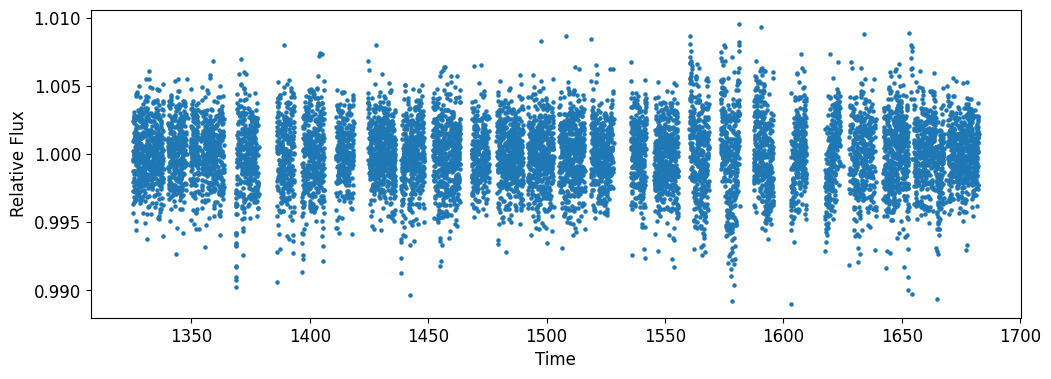

In [5]:
# Raw Light curve 
fig=plt.figure(figsize=(12, 4))
plt.rcParams.update({'font.size': 12})
plt.scatter(phot.time,phot.flux, s=5)
plt.xlabel('Time')
plt.ylabel('Relative Flux')
plt.show()

Starting clipping: Window=2.0 days, Sigma=3.0
  Iteration 1: flagged 27 new outliers.
  Iteration 2: flagged 3 new outliers.
  Iteration 3: flagged 1 new outliers.
  Iteration 4: flagged 0 new outliers.


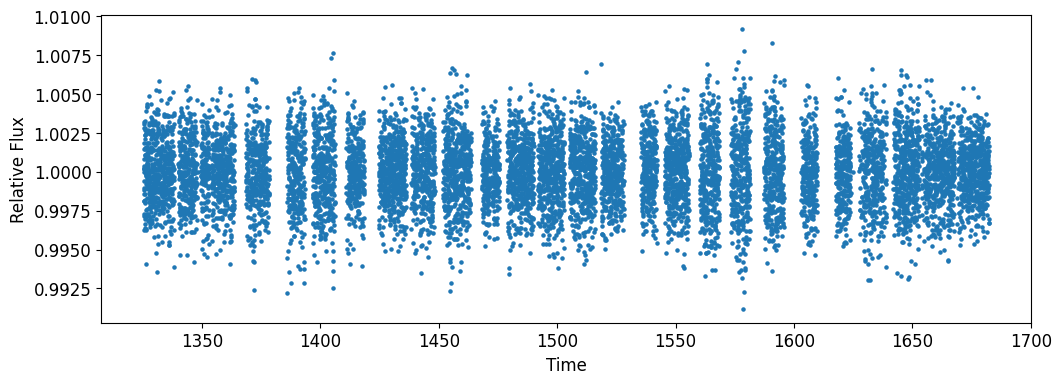

In [6]:
## For testing detrending and outlier removal (can be removed)
phot.flux_f = np.copy(phot.flux)                # Make a copy of original flux
phot.icut = np.zeros(len(phot.time), dtype=int) # Initialize icut array to zero (good data)

# Get default parameters
tpy5_inputs = tpy5.tpy5_inputs_class()

# Run the detrending and outlier detection (if needed) 
tpy5_inputs.boxbin = 5.0 # set detrending length
tpy5_inputs.nfitp  = 3   # Set polynomial order
tpy5.run_polyfilter(phot, tpy5_inputs)  # flux_f will contain the filtered photometry
tpy5.run_cutoutliers(phot, tpy5_inputs) # data clipping, phot.icut will flag bad data
# tpy5.run_sigclip_global(phot, tpy5_inputs) # Simple sigma-clipping of data
tpy5.time_window_clip(phot, tpy5_inputs)  # Example of custom time-window clipping function

# Processed Light curve 
fig=plt.figure(figsize=(12, 4))
plt.rcParams.update({'font.size': 12})
plt.scatter(phot.time[(phot.icut==0)],phot.flux_f[(phot.icut==0)], s=5)
# plt.scatter(phot.time[phot.icut==0],phot.flux_f[phot.icut==0], s=5)
plt.xlabel('Time')
plt.ylabel('Relative Flux')
plt.show()

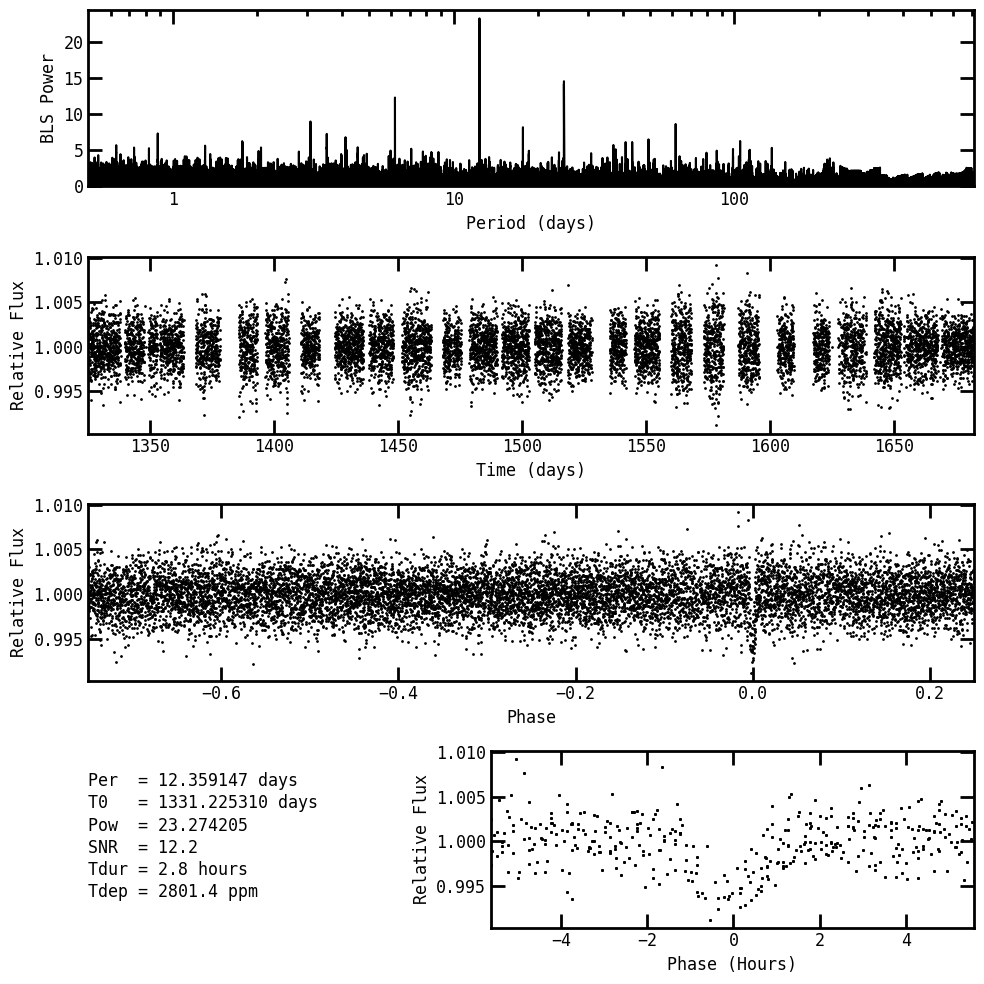

In [11]:
# Set up the BLS inputs and run
gbls_inputs          = gbls.gbls_inputs_class() # Initialize needed inputs
gbls_inputs.zerotime = 0.0
gbls_inputs.Rstar    = 1.0
gbls_inputs.Mstar    = 1.0
gbls_inputs.plots    = 1 # 1=X11, 2=both, 0=none
# Set frequency range
# For long periods: frequency = 1/period (cycles/day = 1/days)
# To search down to period = baseline, use freq1 = 1/baseline
gbls_inputs.freq1    = 0.5 / (np.max(phot.time) - np.min(phot.time))  # Longest period = dataset length
gbls_inputs.freq2    = -1 # default is 2.0 c/d (period = 0.5 days)
gbls_inputs.filename = "BLS_Test"  # Used for naming the file, extension replaced with PNG.


gbls_inputs.normalize = "mad"  # "coverage_mad" "mad", "percentile_mad", "none"

# Run BLS, applying data cuts
gbls_ans = gbls.bls(gbls_inputs, phot.time[(phot.icut==0)], \
                                 phot.flux_f[(phot.icut==0)])

## Python Transit modelling section

- needs preconditioning of data prior to modelling. (protect transits during detrending and clipping)
- move zerotime to routine to leave original phot.time intack
- use flux_f instead of flux for modelling -- leaves original photometry intack
- use icut and other flags to mark bad data 

In [127]:
import pytfit5.transitmodel as transitm
import pytfit5.keplerian as kep
import pytfit5.transitfit as transitf
import pytfit5.transitplot as transitp

# Check for optional exotic limb darkening package.
if importlib.util.find_spec("exotic_ld"):
    from exotic_ld import StellarLimbDarkening
    use_exotic_ld = 1
else:
    use_exotic_ld = 0

In [128]:
# Create an initial guess for all 18 parameters
sol     = transitm.transit_model_class() # Single planet model has up-to 18-model parameters

# Parameters that define the star/scene for the transit model
sol.rho = kep.rhostar(gbls_ans.bper, gbls_ans.tdur)    # Guess for mean stellar density based on transit-duration and period (g/cm^3)
sol.nl1 = 0.0    # Only used for non-linear limb-darkening 
sol.nl2 = 0.0    # Only used for non-linear limb-darkening
sol.dil = 0.0    # dilution
sol.vof = 0.0    # Velocity offset
sol.zpt = 0.0    # Photometric zero point

# Set up Limb-darkening (q1, q2 parameterization)
if use_exotic_ld == 1:
    ld_data_path = './exotic_ld_data/'  #location of exotic spectral library 
    ld_model = 'mps1'
    sld = StellarLimbDarkening(tpy5_inputs.feh, tpy5_inputs.teff, tpy5_inputs.logg, ld_model, ld_data_path)
    ld, ld_sig = sld.compute_kipping_ld_coeffs(wavelength_range=[0.6*10000, 1.0*10000], mode="TESS", mu_min=0.1, return_sigmas=True)
    sol.nl3 = ld[0]
    sol.nl4 = ld[1]
else:
    sol.nl3 = 0.311 #Solar values for TESS
    sol.nl4 = 0.270 

#The parameters below are stored as arrays, as the model is multi-planet ready.
sol.t0  = [gbls_ans.epo]             # Center of transit time (days)
sol.per = [gbls_ans.bper]            # Orbital Period (days)
sol.bb  = [0.5]                      # Impact parameter
sol.rdr = [np.sqrt(gbls_ans.depth)]  # Rp/R*
sol.ecw = [0.0]                      # sqrt(e)cos(w)
sol.esw = [0.0]                      # sqrt(e)sin(w)
sol.krv = [0.0]                      # RV amplitude (m/s)
sol.ted = [0.0]                      # thermal eclipse depth (ppm)
sol.ell = [0.0]                      # Ellipsodial variations (ppm)
sol.alb = [0.0]                      # Albedo amplitude (ppm)
sol.npl = 1                          # Number of planets

In [129]:
# Mark in-transit data.  Since BLS will likely underestimate the transit-duration, we will pad to be safe.
kep.mark_intransit_data(phot, sol, tdurcut = 1.0)  # tdurcut is the amount of +/- time to protect centred on the transit 
tpy5.run_polyfilter(phot, tpy5_inputs)         # Re-apply detrending to protect the transit event from distortion

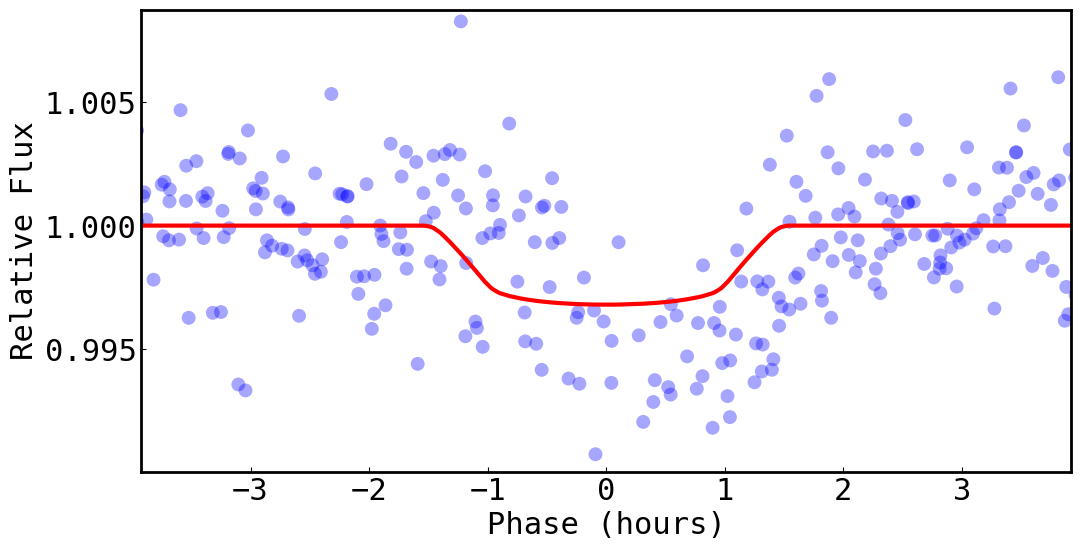

In [130]:
# Plot the initial model and data
pl_plot = 1 # Which planet to plot
transitp.plotTransit(phot, sol, pl_to_plot=pl_plot)

In [131]:
# Define the parameters to fit
params_to_fit = ["rho", "zpt", "t0", "per", "bb", "rdr"]

# Fit the data
sol_fit = transitf.fitTransitModel(sol, params_to_fit, phot)

In [132]:
# See the fitted parameter (Note the error is a simple co-variance matrix at this stage)
transitp.printParams(sol_fit)

ρ* (g/cm³):                    17.4694674 ± 151.1662787
c1:                                   0.0 ± 0.0
c2:                                   0.0 ± 0.0
q1:                                 0.311 ± 0.0
q2:                                  0.27 ± 0.0
Dilution:                             0.0 ± 0.0
Velocity Offset:                      0.0 ± 0.0
Photometric zero point:        -1.366e-04 ± 2.251e-04
t0 (days):                      1.331e+03 ± 3.131e-03
Period (days):                 12.3590484 ± 0.0001938
Impact parameter:               0.1847128 ± 15.0535316
Rp/R*:                          0.0697832 ± 0.0341541
sqrt(e)cos(w):                        0.0 ± 0.0
sqrt(e)sin(w):                        0.0 ± 0.0
RV Amplitude (m/s):                   0.0 ± 0.0
Thermal eclipse depth (ppm):          0.0 ± 0.0
Ellipsoidal variations (ppm):         0.0 ± 0.0
Albedo amplitude (ppm):               0.0 ± 0.0


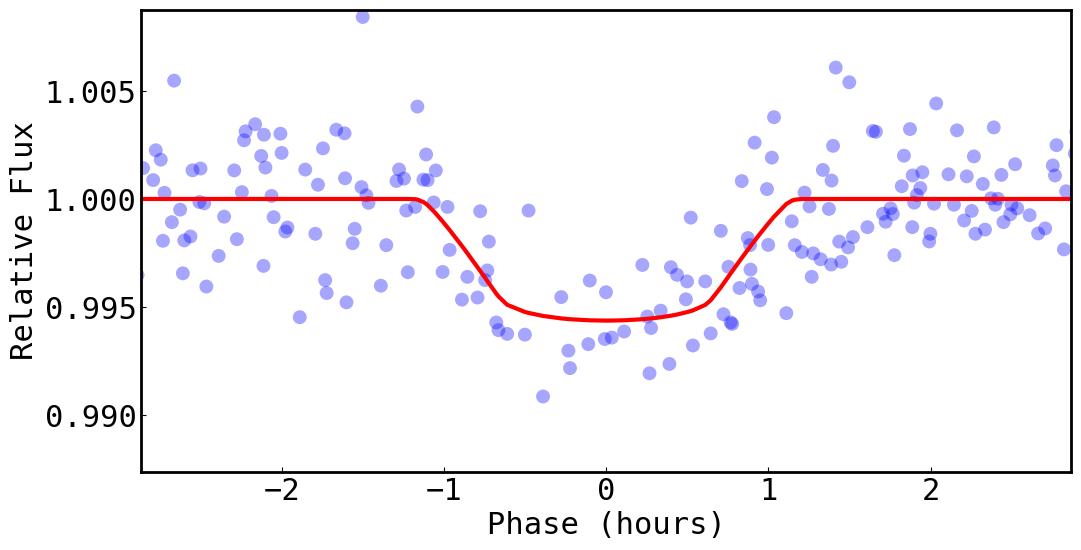

In [133]:
# Plot the optimized model and data
pl_plot = 1
transitp.plotTransit(phot, sol_fit, pl_to_plot=pl_plot)

## MCMC

- add tqdm to MCMC chain generation to give user an indication of progress
- add flag to remove verbose output
- add figure generation that plots a selection of models from MCMC to show scatter. 

In [134]:
import pytfit5.transitmcmc as tmcmc

In [142]:
nsteps1 = 10000 #total length of chain will be nwalkers*nsteps
nsteps2 = 50000#200000 #nstep1 is to check that MCMC is okay, nstep2 is the real work.
nsteps_inc = 50000#100000
burninf=0.2 #burn-in for evalulating convergence
niter_cor=10000
burnin_cor=1000
nthin=101
nloopmax=5
converge_crit=1.02 #Convergence criteria
buf_converge_crit=1.2 #Convergence criteria for buffer

In [143]:
if np.rint(np.median(phot.flux)) != 1:
    raise ValueError

# Generate input for mcmc
lnprob, x, beta = tmcmc.genmcmcInput(sol_fit, params_to_fit)  # Beta can be crap when pulled from least-squares...

# # beta is the step size for each parameter in x and initialized from the covariance matrix.
# # Here we set some reasonable values for our parameters to fit. 
# beta[0] = 0.01 # Set a reasonable step size for stellar density
# beta[1] = 0.00001 # Set a reasonable step size for photometric zero point
# beta[2] = 0.00001 # Set a reasonable step size for transit time
# beta[3] = 0.00001 # Set a reasonable step size for period
# beta[4] = 0.1  # Set a reasonable step size for impact parameter
# beta[5] = 0.0001 # Set a reasonable step size for radius ratio

sol_a = sol_fit.to_array()
serr = sol_fit.err_to_array()

# Cut out of transit
phot_cut = tmcmc.cutOutOfTransit(sol_fit, phot)

params = [nsteps1, nsteps2, nsteps_inc, burninf, niter_cor, burnin_cor, nthin, nloopmax, converge_crit, buf_converge_crit]

In [144]:
# Run the DEMCMC routine.
chain, accept, burnin = tmcmc.demcmcRoutine(x, beta, phot_cut, sol_a, serr, params, lnprob)

runtest: [0.00418976 0.00301556 0.00029845 0.00025684]
Current Acceptance:  [0.02610442 0.64713627 0.54230769 0.56391478 0.00746269 0.10836763]
Current Acceptance:  [0.06517312 0.39867987 0.33202358 0.36500342 0.02094595 0.15622983]
Current Acceptance:  [0.21059691 0.17037037 0.20946822 0.19031607 0.1236246  0.24365134]
Current Acceptance:  [0.37900477 0.12024457 0.15880399 0.15379665 0.41555851 0.24365134]
Current Acceptance:  [0.43654485 0.17325428 0.18965517 0.17938144 0.49074709 0.24365134]
Current Acceptance:  [0.33595285 0.22347154 0.22721268 0.23275306 0.31109598 0.24365134]
Current Acceptance:  [0.25959662 0.22347154 0.22721268 0.23275306 0.04780362 0.24365134]
Current Acceptance:  [0.25959662 0.22347154 0.22721268 0.23275306 0.21210061 0.24365134]
Current Acceptance:  [0.25959662 0.22347154 0.22721268 0.23275306 0.25782811 0.24365134]
Final Acceptance:  [0.25959662 0.22347154 0.22721268 0.23275306 0.25782811 0.24365134]
Global Acceptance Rate: 0.289
0 Acceptance Rate 0.165
1 A

In [145]:
# Get statistics about the posterior from the Markov-Chain and print the results
sol_mcmc = tmcmc.getParams(chain, burnin, sol, params_to_fit)
transitp.printParams(sol_mcmc)

# you can get any individual value from the sol_mcmc class, for example the mean stellar density : rho and drho 

ρ* (g/cm³):                     4.8838983 ± 6.4086955
c1:                                   0.0 ± 0.0
c2:                                   0.0 ± 0.0
q1:                                 0.311 ± 0.0
q2:                                  0.27 ± 0.0
Dilution:                             0.0 ± 0.0
Velocity Offset:                      0.0 ± 0.0
Photometric zero point:        -1.176e-04 ± 2.409e-04
t0 (days):                      1.331e+03 ± 3.763e-03
Period (days):                 12.3590670 ± 0.0002635
Impact parameter:               0.7592205 ± 0.4659740
Rp/R*:                          0.0755592 ± 0.0611914
sqrt(e)cos(w):                        0.0 ± 0.0
sqrt(e)sin(w):                        0.0 ± 0.0
RV Amplitude (m/s):                   0.0 ± 0.0
Thermal eclipse depth (ppm):          0.0 ± 0.0
Ellipsoidal variations (ppm):         0.0 ± 0.0
Albedo amplitude (ppm):               0.0 ± 0.0


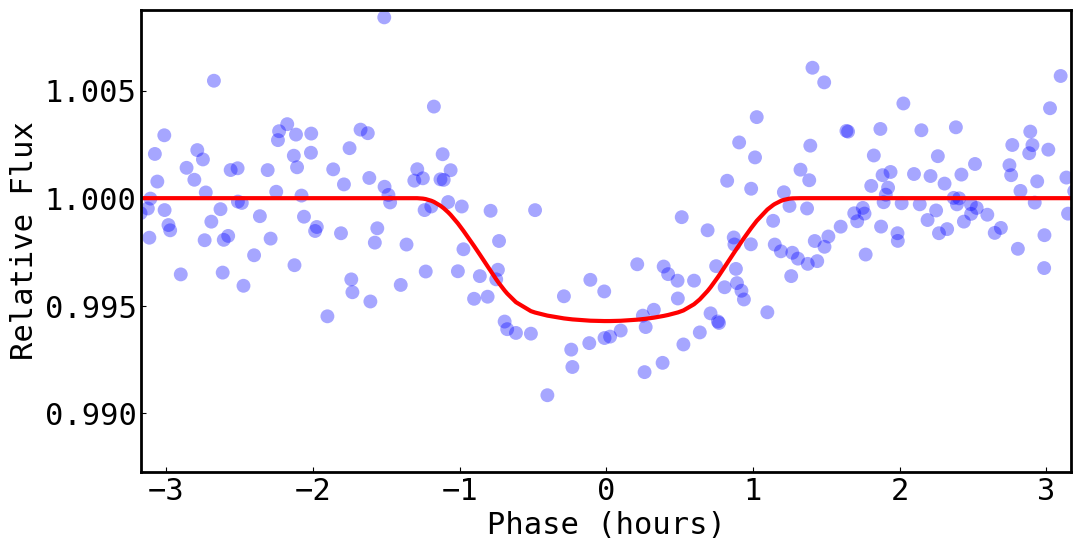

In [146]:
pl_plot = 1
transitp.plotTransit(phot, sol_mcmc, pl_to_plot=pl_plot)

In [147]:
import pytfit5.mcmcroutines as mcmc

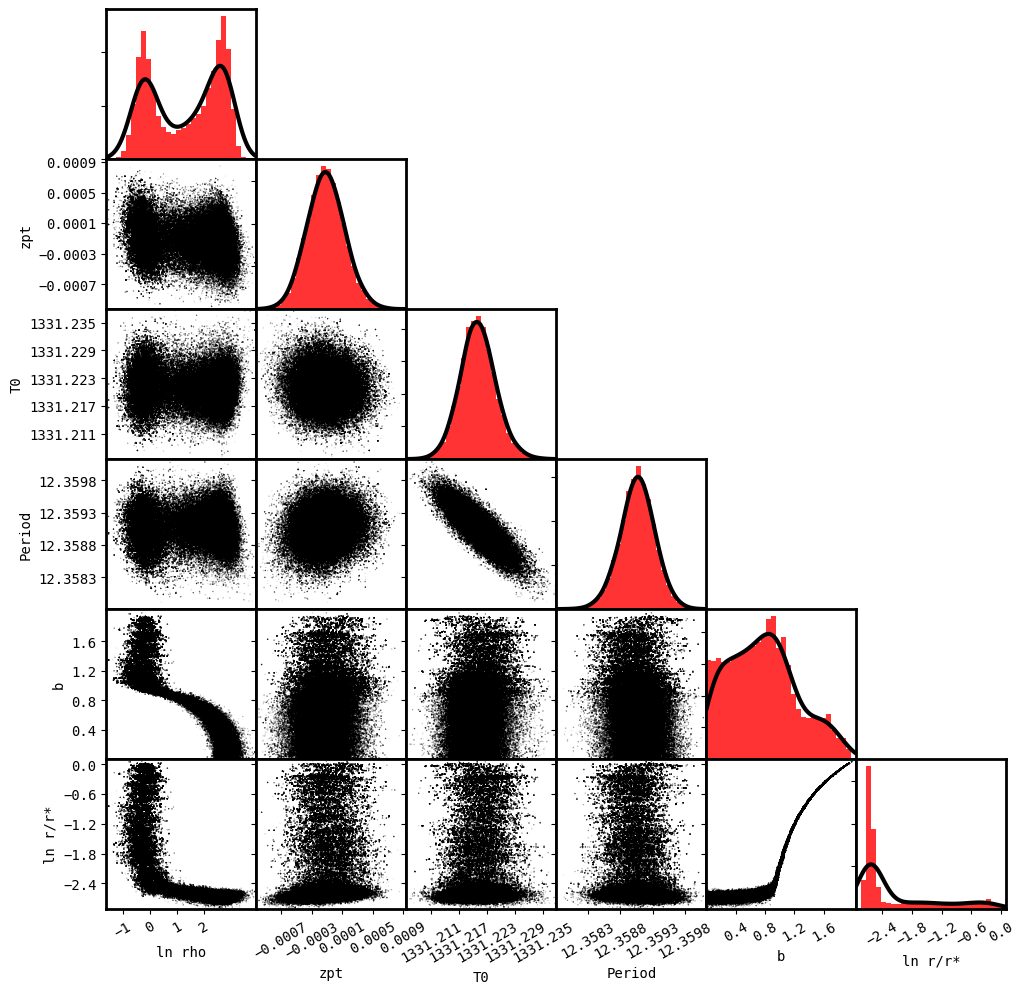

In [148]:
label = ["ln rho", "zpt", "T0", "Period", "b", "ln r/r*"]
color = ["red"]*14

plt.rcParams['font.size'] = 10
mcmc.triplot(chain, burnin, label, color, 30)

## Synthetic Lightcurve Generator Demo

Use `utils_python/synthetic.generate_synthetic_lightcurve` to create a simple Sun-like transit signal for BLS testing.

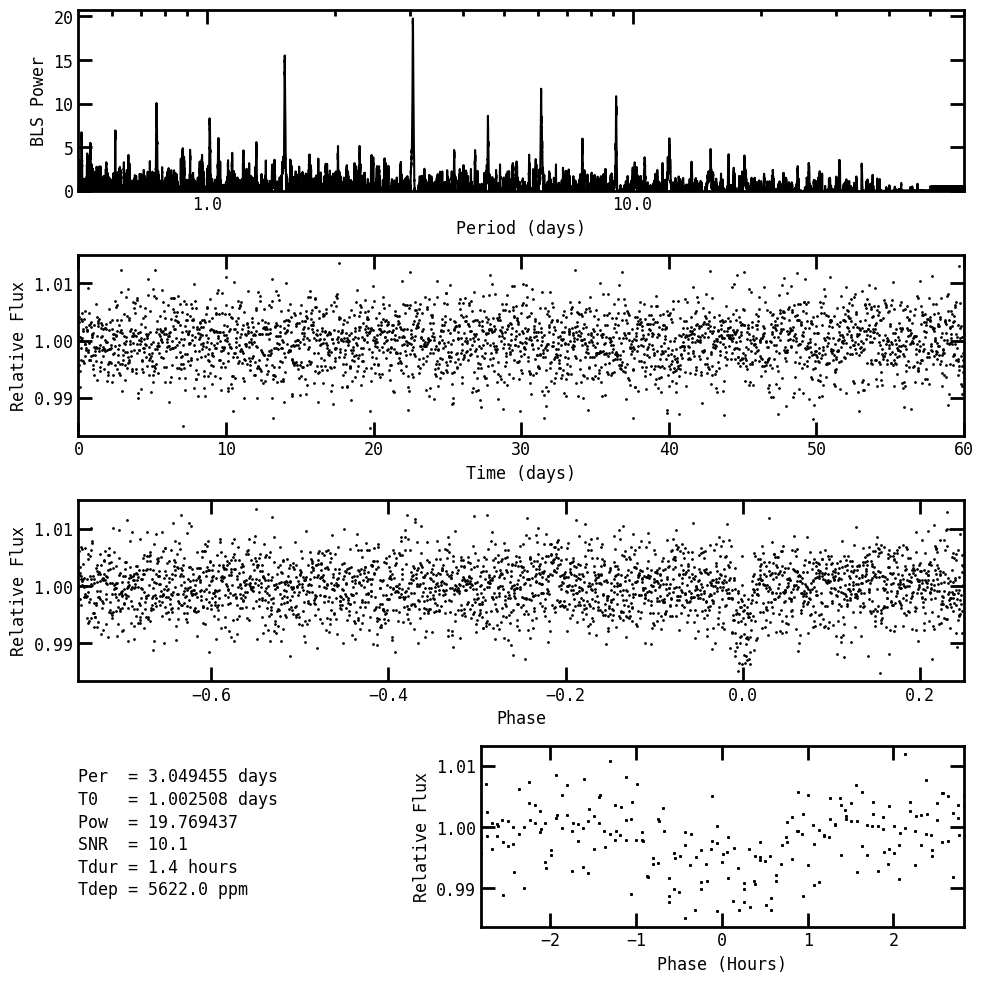

{'epo': np.float64(1.0025082338733238),
 'bper': np.float64(3.0494547037971826),
 'bpower': np.float64(19.769436889342224),
 'snr': 10.051129706000374,
 'tdur': np.float64(0.059464366724045065),
 'depth': 0.005621950096976334}

In [ ]:
# Generate synthetic photometry and run BLS
from utils_python.synthetic import generate_synthetic_lightcurve

# Parameters: t0, per, time_length, depth, snr
syn_time, syn_flux = generate_synthetic_lightcurve(
    t0=1.0,            # days
    per=3.05,           # days
    time_length=60.0,  # days total baseline
    depth=0.005,       # 0.5% depth
    snr=10.0,          # integrated transit SNR
    cadence=1.0/48.0,  # 30-min cadence
    seed=42,
)

# Prepare phot class-like arrays for BLS
phot_syn_time = syn_time
phot_syn_flux = syn_flux

# Configure BLS for synthetic data
syn_inputs = gbls.gbls_inputs_class()
syn_inputs.zerotime = 0.0
syn_inputs.Rstar = 1.0
syn_inputs.Mstar = 1.0
syn_inputs.plots = 1
syn_inputs.freq1 = 1.0 / (np.max(phot_syn_time) - np.min(phot_syn_time))  # longest period = baseline
syn_inputs.freq2 = 2.0  # c/d
syn_inputs.filename = "BLS_Synthetic"

# Normalization options: "none", "mad", "percentile_mad", "coverage_mad", "iterative_baseline"
# For high SNR signals, "iterative_baseline" is more robust against suppressing the main peak
syn_inputs.normalize = "iterative_baseline"

# Run BLS on synthetic data
syn_ans = gbls.bls(syn_inputs, phot_syn_time, phot_syn_flux)

# Display results
syn_ans.__dict__